In [3]:
from cosapp.base import System
from cosapp.drivers import RunOnce
import numpy as np

# **Global System**

In [4]:
class Earth(System):

    def setup(self):

        self.add_child(Gravity('grav'))
        self.add_child(Atmosphere('atmo'))
        self.add_child(Trajectory('traj'))
        self.add_child(Rocket('rocket'))
        self.add_child(Reservatory('reserv'))

# **Earth Properties**

In [5]:
class Gravity(System):

    def setup(self):

        self.add_inward('x')

In [6]:
class Atmosphere(System):

    def setup(self):

        self.add_child(Density('dens'))
        self.add_child(Pressure('pres'))

In [7]:
class Pressure(System):

    def setup(self):

        self.add_inward('x')

In [8]:
class Density(System):

    def setup(self):

        self.add_inward('x')

# **Station's Reservatory**

In [9]:
class Reservatory(System):
    
    def setup(self):
        
        self.add_inward('x')

# **Rocket Trajectory**

In [10]:
class Trajectory(System):

    def setup(self):

        self.add_inward('x')

# **Rocket System**

In [115]:
class Rocket(System):

    def setup(self):

        self.add_child(Fins('fins'))
        self.add_child(Nose('nose'))
        self.add_child(Tube('tube'))
        self.add_child(Engine('engine'))
        self.add_child(Tank('tank'))
        self.add_child(RocketAero('aero'))
        self.add_child(RocketGeom('geom'))
        self.add_child(Dynamics('dyn'))
        self.add_child(Kinematics('kin'))
        
        self.connect(self.fins, self.aero, ['Ar_fins', 'Cna_1', 'y_mac', 'RGC', 'RDIF', 'RFIF', 'delta', 'R_fins', 'Cd_fins', 'Cna_fins', 'Aw_fins', 'tf', 'c_bar', 'Xcp_fins', 'Lf'])
        self.connect(self.nose, self.aero, ['Ar_nose', 'Cd_nose', 'Cna_nose', 'Aw_nose', 'L_nose', 'Xcp_nose'])
        self.connect(self.tube, self.aero, ['R_tube', 'L_tube', 'Aw_tube'])

# **Rocket Components**

## Fins

In [97]:
class Fins(System):

    def setup(self):

        #Fins known Parameters
        self.add_inward('n', 4., desc="Number of fins", unit='')
        self.add_inward('s', 0.1, desc="Span of one fin", unit='m')
        self.add_inward('Cr', 0.1, desc="See image", unit='m')
        self.add_inward('Ct', 0.1, desc="See image", unit='m')
        self.add_inward('Xt', 0.1, desc="See image", unit='m')
        self.add_inward('tf', 0.001, desc="Fin thickness", unit='m')
        self.add_inward("delta", 0.0, desc="Fin cant angle", unit="")
        self.add_inward('rho', 300., desc="Fin material density", unit = 'kg/m**3')
        self.add_inward('Lf', 1., desc="Distance from fin tip to nose cone", unit='m')
        self.add_inward('R_fins', 1., desc="Tube radius at fins' position", unit='m')
        
        #Rocket velocity
        self.add_inward('v', np.zeros(3), desc="Rocket velocity relative to air", unit='m/s')
        
        #Fins children
        self.add_child(FinsGeom('geom'), pulling=['n', 's', 'Cr', 'Ct', 'Xt', 'tf', 'R_fins', 'rho', 'Xcg_fins', 'm_fins', 'I_fins'])
        self.add_child(FinsAero('aero'), pulling=['n', 's', 'Cr', 'Ct', 'Xt', 'tf', 'R_fins', 'v', 'Cna_1', 'Cna_fins', 'Cd_fins', 'Xcp_fins', 'Ar_fins', 'Aw_fins', 'c_bar', 'y_mac', 'RGC', 'RDIF', 'RFIF'])
        
        

In [96]:
class FinsGeom(System):
    
    def setup(self):
        
        #Fins known parameters
        self.add_inward('n', 4., desc="Number of fins", unit='')
        self.add_inward('s', 0.1, desc="Span of one fin", unit='m')
        self.add_inward('Cr', 0.1, desc="See image", unit='m')
        self.add_inward('Ct', 0.1, desc="See image", unit='m')
        self.add_inward('Xt', 0.1, desc="See image", unit='m')
        self.add_inward('tf', 0.001, desc="Fin thickness", unit='m')
        self.add_inward('R_fins', 1., desc="Tube radius at fins' position", unit='m')
        self.add_inward('rho', 300., desc="Fin material density", unit = 'kg/m**3')
        
        #Fins geometric outputs
        self.add_outward('Xcg_fins', 1., desc="Center of gravity x-coordinate", unit='m')
        self.add_outward('m_fins', 1., desc="Fins mass", unit='kg')
        self.add_outward('I_fins', np.ones(3), desc="Fins principal inertia moments", unit='kg*m**2')
        
    def compute(self):
        
        #Gamma c (see image)
        gc = np.atan2(self.Xt + 0.5*(self.Ct - self.Cr),self.s)
        
        #Fins mass
        self.m_fins = self.n * self.rho * self.tf * (self.Cr + self.Ct)*self.s/2
        
        #Fins center of gravity
        self.Xcg_fins = self.Cr/2 + self.s * np.tan(gc)/2
        
        #Fins principal inertia moments
        
        Ix = self.n * self.m * (self.s/2 + self.R_fins)**2
        Iy = Ix/2
        
        self.I_fins = np.array([Ix, Iy, Iy])
        

In [95]:
class FinsAero(System):
    
    def setup(self):
        
        #Fins known parameters
        self.add_inward('n', 4., desc="Number of fins", unit='')
        self.add_inward('s', 0.1, desc="Span of one fin", unit='m')
        self.add_inward('Cr', 0.1, desc="See image", unit='m')
        self.add_inward('Ct', 0.1, desc="See image", unit='m')
        self.add_inward('Xt', 0.1, desc="See image", unit='m')
        self.add_inward('tf', 0.001, desc="Fin thickness", unit='m')
        self.add_inward('R_fins', 1., desc="Tube radius at fins' position", unit='m')
        
        #Rocket velocity
        self.add_inward('v', np.zeros(3), desc="Rocket velocity relative to air", unit='m/s')
        
        #Fins aerodynamical values/properties
        self.add_inward('coefs', np.array([1., 1., 1., 1., 0.948, 0.913, 0.854, 0.810, 0.750]), desc="Correction coefficients", unit='')
        self.add_inward('vsound', 340.29, desc="Sound velocity", unit='m/s')
        
        #Fins aerodynamical outputs
        self.add_outward('Cna_1', 2., desc="1 fin normal force coefficient slope", unit='')
        self.add_outward('Cna_fins', 2., desc="Fins normal force coefficient slope", unit='')
        self.add_outward('Cd_fins', 1., desc="Fins drag coefficient", unit='')
        self.add_outward('Xcp_fins', 1., desc="Fins center of pressure", unit='m')
        self.add_outward('Ar_fins', 1., desc="Fins Area of drag effect", unit='m**2')
        self.add_outward('Aw_fins', 1., desc="Fins wetted area", unit='m**2')
        self.add_outward('c_bar', 1., desc="Fins mean aerodynamic chord length", unit='m')
        self.add_outward('y_mac', 1., desc="Position of mean aerodynamic chord length", unit='m')
        self.add_outward('RGC', 1., desc="Roll geometrical constant", unit='')
        self.add_outward('RDIF', 1., desc="Roll damping interference factor", unit='')
        self.add_outward('RFIF', 1., desc="Roll forcing interference factor", unit='')
        
    def compute(self):
        
        ## Source: https://openrocket.info/documentation.html (download first pdf)
        
        #Fins frontal surface (reference area)
        self.Ar_fins = self.n * self.s * self.tf
        
        #Fins lateral surface (wetted area)
        self.Aw_fins = self.n*(self.Ct + self.Cr)*self.s/2
        
        #Fins extended surface
        Af = Ae + self.Cr*self.R_fins
        
        #Fins gamma c angle (see image)
        gc = np.atan2(self.Xt + 0.5*(self.Ct - self.Cr),self.s)
        
        #Mach number
        M = np.linalg.norm(self.v)/self.vsound
        
        #Mean aerodynamic chord length
        self.c_bar = (2/3)*(self.Cr + self.Ct + self.Cr*self.Ct/(self.Cr + self.Ct))
        
        #Position of mean aerodynamic chord length
        self.y_mac = (self.s / 3) * (self.Cr + 2 * self.Ct) / (self.Cr + self.Ct)
        
        #Correction coefficients
        if self.n <= 8:
            coef = self.coefs[n - 1]
        else:
            coef = self.coefs[8]
            
        #Normal force coefficient slope for one fin
        self.Cna_1 = (self.s/self.R_fins)**2 / (1 + np.sqrt(1 + (s**2/(np.cos(gc)*self.Aw_fins))))
        
        #Normal force coefficient slope
        self.Cna_fins = coef * self.n * (1 + self.R_fins/(self.s + self.R_fins)) * self.Cna_1
        
        #Fins center of pressure
        self.Xcp_fins = (self.s*(self.Cr + 2*self.Ct)/(3*np.cos(gc)) + (self.Cr**2 + self.Ct**2 + self.Cr*self.Ct)/6)/(self.Cr + self.Ct)
        
        #Drag coefficient due to drag on fins' base
        Cd_base = 0.12 + 0.13*M**2
        
        #Drag coefficient due to pressure drag on fins
        Cd_fin_pressure = ((1 - M**2)**(-0.417) - 1)*np.cos(gc)**2
        
        #Total drag coefficient
        self.Cd_fins = Cd_base + Cd_fin_pressure
        
        #### Rolling Coefficients ####
        
        #Adimensional parameters
        lbd = self.Ct / self.Cr
        tau = (self.s + self.R_fins) / self.R_fins
        
        #Roll geometrical constant
        self.RGC = (
            (self.Cr + 3 * self.Ct) * self.s**3
            + 4 * (self.Cr + 2 * self.Ct) * self.R_fins * self.s**2
            + 6 * (self.Cr + self.Ct) * self.s * self.R_fins**2
        ) / 12
        
        
        #Roll damping interference factor
        self.RDIF = 1 + (
            ((tau - lbd) / (tau)) - ((1 - lbd) / (tau - 1)) * np.log(tau)
        ) / (
            ((tau + 1) * (tau - lbd)) / (2) - ((1 - lbd) * (tau**3 - 1)) / (3 * (tau - 1))
        )
        
        
        #Roll forcing interference factor
        self.RFIF = (1 / np.pi**2) * (
            (np.pi**2 / 4) * ((tau + 1) ** 2 / tau**2)
            + ((np.pi * (tau**2 + 1) ** 2) / (tau**2 * (tau - 1) ** 2))
            * np.arcsin((tau**2 - 1) / (tau**2 + 1))
            - (2 * np.pi * (tau + 1)) / (tau * (tau - 1))
            + ((tau**2 + 1) ** 2)
            / (tau**2 * (tau - 1) ** 2)
            * (np.arcsin((tau**2 - 1) / (tau**2 + 1))) ** 2
            - (4 * (tau + 1))
            / (tau * (tau - 1))
            * np.arcsin((tau**2 - 1) / (tau**2 + 1))
            + (8 / (tau - 1) ** 2) * np.log((tau**2 + 1) / (2 * tau))
        )
        
        

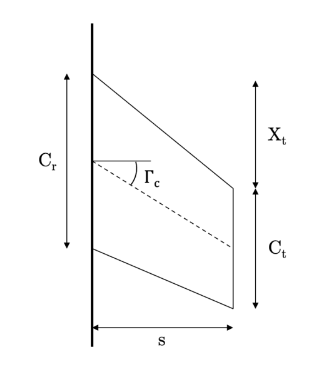

## Nose - Cone

In [92]:
class Nose(System):

    def setup(self):
        
        #Nose known parameters
        self.add_inward('R_nose', 1., desc="Nose radius", unit='m')
        self.add_inward('L_nose', 1., desc="Nose length", unit='m')
        self.add_inward('rho', 300., desc="Nose Density", unit='kg/m**3')
        
        #Nose children
        self.add_child(NoseGeom('geom'), pulling=['R_nose', 'L_nose', 'rho', 'Xcg_nose', 'm_nose', 'I_nose'])
        self.add_child(NoseAero('aero'), pulling=['R_nose', 'L_nose', 'Cna_nose', 'Cd_nose', 'Xcp_nose', 'Ar_nose', 'Aw_nose'])
        

In [93]:
class NoseGeom(System):
    
    def setup(self):
        
        #Nose known parameters
        self.add_inward('R_nose', 1., desc="Nose radius", unit='m')
        self.add_inward('L_nose', 1., desc="Nose length", unit='m')
        self.add_inward('rho', 300., desc="Nose Density", unit='kg/m**3')
        
        #Nose geometric outputs
        self.add_outward('Xcg_nose', 1., desc="Center of gravity x-coordinate", unit='m')
        self.add_outward('m_nose', 1., desc="Nose mass", unit='kg')
        self.add_outward('I_nose', np.ones(3), desc="Nose principal inertia moments", unit='kg*m**2')
        
    def compute(self):
        
        #Nose volume
        V = self.L_nose*np.pi*self.R_nose**2/3
        
        #Nose mass
        self.m_nose = self.rho*V
        
        #Nose center of gravity
        self.Xcg_nose = 3*self.L_nose/4
        
        #Nose inertia moments
        Ix = (3/10)*self.m_nose*self.R_nose**2
        Iy = (3*self.m_nose/20)*(self.R_nose**2 + self.L_nose**2/4)
        
        self.I_nose = np.array([Ix, Iy, Iy])

In [94]:
class NoseAero(System):
    
    def setup(self):
        
        #Nose known parameters
        self.add_inward('R_nose', 1., desc="Nose radius", unit='m')
        self.add_inward('L_nose', 1., desc="Nose length", unit='m')
        
        #Nose aerodynamical outputs
        self.add_outward('Cna_nose', 2., desc="Nose normal force coefficient slope", unit='')
        self.add_outward('Cd_nose', 1., desc="Nose drag coefficient", unit='')
        self.add_outward('Xcp_nose', 1., desc="Nose center of pressure", unit='m')
        self.add_outward('Ar_nose', 1., desc="Nose effective surface", unit='m**2')
        self.add_outward('Aw_nose', 1., desc="Nose wetted surface", unit='m**2')
        
    def compute(self):
        
        #Nose frontal area (reference area)
        self.Ar_nose = np.pi * self.R_nose**2
        
        #Nose lateral area (wetted area)
        self.Aw_nose = np.pi * self.R_nose * np.sqrt(self.R_nose**2 + self.L_nose**2)
        
        #Nose center of pressure
        self.Xcp_nose = 2*self.L_nose/3
        
        #Nose drag coefficient
        self.Cd_nose = 0.8*self.R_nose**2/(self.R_nose**2 + self.L_nose**2)

## Tube

In [87]:
class Tube(System):

    def setup(self):
        
        #Tube known parameters
        self.add_inward('R_tube', 1., desc="Tube radius", unit='m')
        self.add_inward('L_tube', 1., desc="Tube length", unit='m')
        self.add_inward('rho', 300., desc="Tube material density", unit='kg/m**3')
        
        #Tube children
        self.add_child(TubeGeom('geom'), pulling=['rho', 'R_tube', 'L_tube', 'Xcg_tube', 'm_tube', 'I_tube'])
        self.add_child(TubeAero('aero'), pulling=['R_tube', 'L_tube', 'Cna_tube', 'Cd_tube', 'Xcp_tube', 'Aw_tube'])

In [89]:
class TubeGeom(System):
    
    def setup(self):
        
        #Tube known parameters
        self.add_inward('R_tube', 1., desc="Tube radius", unit='m')
        self.add_inward('L_tube', 1., desc="Tube length", unit='m')
        self.add_inward('rho', 300., desc="Tube material density", unit='kg/m**3')
        
        #Tube geometric outputs
        self.add_outward('Xcg_tube', 1., desc="Center of gravity x-coordinate", unit='m')
        self.add_outward('m_tube', 1., desc="Tube mass", unit='kg')
        self.add_outward('I_tube', np.ones(3), desc="Tube principal inertia moments", unit='kg*m**2')
        
    def compute(self):
        
        #Tube center of gravity
        self.Xcg_tube = self.L_tube/2
        
        #Tube mass
        self.m_tube = self.rho * self.L_tube * np.pi * self.R_tube**2
        
        #Tube inertia moments
        Iy = self.m_tube * self.R_tube**2/4 + self.m_tube * self.L_tube**2/12
        Ix = self.m_tube * self.R_tube**2/2
        
        self.I_tube = np.array([Ix, Iy, Iy])

In [86]:
class TubeAero(System):
    
    def setup(self):
        
        #Tube known parameters
        self.add_inward('R_tube', 1., desc="Tube radius", unit='m')
        self.add_inward('L_tube', 1., desc="Tube length", unit='m')
        
        #Tube aerodynamical outputs
        self.add_outward('Cna_tube', 0., desc="Tube normal force coefficient slope", unit='')
        self.add_outward('Cd_tube', 0., desc="Tube drag coefficient", unit='')
        self.add_outward('Xcp_tube', 1., desc="Tube center of pressure", unit='m')
        self.add_outward('Aw_tube', 1., desc="Tube wetted surface", unit='m**2')
        
    def compute(self):
        
        #Tube center of pressure
        self.Xcp_tube = self.L_tube/2
        
        #Tube lateral surface (wetted surface)
        self.Aw_tube = 2*np.pi*self.R_tube*self.L_tube
        

## Engine

In [21]:
class Engine(System):

    def setup(self):

        self.add_inward('x')

## Fuel Tank

In [22]:
class Tank(System):

    def setup(self):

        self.add_inward('x')

# **Rocket overall geometry**

In [56]:
class RocketGeom(System):
    
    def setup(self):
        
        ## Will compute the total mass, moments of inertia and center of gravity
        self.add_inward('x')

# **Rocket overall aerodynamics**

In [116]:
class RocketAero(System):
    
    def setup(self):
        
        self.add_child(Aeroforces('afor'), pulling=['rho', 'v', 'Ar_fins', 'Ar_nose', 'Fa'])
        self.add_child(Moments('moments'), pulling=['Cna_1', 'y_mac', 'RGC', 'RDIF', 'RFIF', 'delta', 'Ar_fins', 'R_fins', 'Ar_nose', 'v', 'av', 'rho', 'Xcg', 'Ma'])
        self.add_child(Coefficients('coef'), pulling=['Cd_fins', 'Cna_fins', 'Ar_fins', 'Aw_fins', 'tf', 'c_bar', 'Cd_nose', 'Cna_nose', 'Ar_nose', 'Aw_nose', 'L_nose', 'R_tube', 'L_tube', 'Aw_tube', 'v'])
        self.add_child(CPA('cpa'), pulling=['Xcp_fins', 'Cna_fins', 'Lf', 'Xcp_nose', 'Cna_nose'])
        
        self.connect(self.afor, self.coef, ['Cd', 'Cn'])
        self.connect(self.afor, self.moments, ['Fa'])
        self.connect(self.cpa, self.moments, ['Xcp'])

In [37]:
class Aeroforces(System):
    
    def setup(self):
        
        #Atmosphere parameters
        self.add_inward('rho', 1., desc="Air density at rocket's height", unit='kg/m**3')
        
        #Rocket parameters
        self.add_inward('v', 1., desc="Rocket velocity relative to air", unit='m/s')
        
        #Fins parameters
        self.add_inward('Ar_fins', 1., desc="Fins reference area", unit='m**2')
        
        #Cone parameters
        self.add_inward('Ar_nose', 1., desc="Nose reference area", unit='m**2')
        
        #Coefficient parameters
        self.add_inward('Cd', 1., desc="Rocket drag coefficient", unit='')
        self.add_inward('Cn', 1., desc="Rocket normal force coefficient", unit='')
        
        #Aerodynamic force
        self.add_outward('Fa', np.zeros(3), desc="Aerodynamic force", unit='N')
        
    def compute(self):
        
        v = np.linalg.norm(self.v)
        
        #Normal force
        Fn = 0.5 * self.Cn * self.rho * v**2 * (self.Ar_fins + self.Ar_nose)
        
        #Drag force
        Fd = 0.5 * self.Cd * self.rho * v**2 * (self.Ar_fins + self.Ar_nose)
        
        #Normal force angle
        a = np.arctan2(v[2],v[1])
        
        #Total aerodynamic force
        self.F = np.array([-Fd, -Fn*np.sin(a), -Fn*np.cos(a)])
        

In [100]:
class Moments(System):
    
    def setup(self):
        
        #Fins parameters
        self.add_inward('Cna_1', 2., desc="1 fin normal force coefficient slope", unit='')
        self.add_inward('y_mac', 1., desc="Position of mean aerodynamic chord length", unit='m')
        self.add_inward('RGC', 1., desc="Roll geometrical constant", unit='')
        self.add_inward('RDIF', 1., desc="Roll damping interference factor", unit='')
        self.add_inward('RFIF', 1., desc="Roll forcing interference factor", unit='')
        self.add_inward("delta", 0.0, desc="Fin cant angle", unit="")
        self.add_inward('Ar_fins', 1., desc="Fins reference area", unit='m**2')
        self.add_inward('R_fins', 1., desc="Tube radius at fins' position", unit='m')
        
        #Nose parameters
        self.add_inward('Ar_nose', 1., desc="Nose reference area", unit='m**2')
        
        #Rocket Velocities
        self.add_inward('v', 1., desc="Rocket velocity relative to air", unit='m/s')
        self.add_inward('av', 1., desc="Rocket angular velocity", unit='1/s')
        
        #Atmosphere density
        self.add_inward('rho', 1., desc="Air density at rocket height", unit='kg/m**3')
        
        #Forces
        self.add_inward('Fn', 1., desc="Value of normal aerodynamic force", unit='N')
        self.add_inward('Fa', 1., desc="Total aerodynamic force", unit='N')
        
        #Positions
        self.add_inward('Xcp', 1., desc="Position of center of pressure", unit='m')
        self.add_inward('Xcg', 1., desc="Position of center of gravity", unit='m')
        
        #Total moment
        self.add_outward('Ma', 1., desc="Aerodynamic moment", unit='N*m')
        
    def compute(self):
        
        v = np.linalg.norm(self.v)
        S_ref = self.Ar_fins + self.Ar_nose
        
        #### ROLLING MOMENT ####
        
        #Forcing moment coefficient
        Clfd = self.RFIF*self.Fn*(self.R_fins + self.y_mac)*self.Cna_1/(2*self.R_fins)
        
        #Damping moment coefficient
        Cldw = self.RDIF*self.Fn*self.Cna_1*np.cos(self.delta)*self.RGC/(4*S_ref*self.R_fins**2)
        
        #Forcing moment
        
        Mlf = self.rho * v**2 * S_ref * self.R_fins * Clfd * self.delta
        
        #Damping moment
        
        Mld = self.rho * v * S_ref * self.R_fins**2 * Cldw * self.av[0]
        
        #Total rolling moment
        
        M_roll = Mlf - Mld
        
        
        #### TOTAL MOMENT ####
        
        OM = np.array([self.Xcg - self.Xcp, 0., 0.])
        self.Ma = np.cross(OM, self.Fa)
        self.Ma[0] += M_roll
        

In [104]:
class Coefficients(System):
    
    def setup(self):
        
        #Fins parameters
        self.add_inward('Cd_fins', 1., desc="Fins drag coefficient", unit='')
        self.add_inward('Cna_fins', 1., desc="Fins normal force coefficient slope", unit='')
        self.add_inward('Ar_fins', 1., desc="Fins reference area", unit='m**2')
        self.add_inward('Aw_fins', 1., desc="Fins wetted area", unit='m**2')
        self.add_inward('tf', 0.001, desc="Fins thickness", unit='m')
        self.add_inward('c_bar', 1., desc="Mean aerodynamic chord length", unit='m')
        
        #Nose parameters
        self.add_inward('Cd_nose', 1., desc="Fins drag coefficient", unit='')
        self.add_inward('Cna_nose', 1., desc="Fins normal force coefficient slope", unit='')
        self.add_inward('Ar_nose', 1., desc="Nose reference area", unit='m**2')
        self.add_inward('Aw_nose', 1., desc="Nose wetted area", unit='m**2')
        self.add_inward('L_nose', 1., desc="Nose length", unit='m')
        
        #Tube parameters
        self.add_inward('Aw_tube', 1., desc="Tube wetted area", unit='m**2')
        self.add_inward('R_tube', 1., desc="Tube radius", unit='m')
        self.add_inward('L_tube', 1., desc="Tube length", unit='m')
        
        #Rocket parameters
        self.add_inward('Rs', 20*10**(-6), desc="Surface roughness", unit='m')
        self.add_inward('v', np.zeros(3), desc="Rocket velocity relative to air", unit='m/s')
        
        #Environment parameters
        self.add_inward('nu', 1., desc="Kinematic viscosity", unit='m**2/s')
        self.add_inward('vsound', 340.29, desc="Sound velocity", unit='m/s')
        
        #Coefficients values
        self.add_outward('Cd', 1., desc="Rocket drag coefficient", unit='')
        self.add_outward('Cn', 1., desc="Rocket normal force coefficient", unit='')
        
    def compute(self):
        
        #### DRAG COEFFICIENT ####
        
        #Rocket velocity
        v = np.linalg.norm(self.v)
        
        #Angle of attack
        alpha = (np.arccos(self.v[0]/v) if v > 0.1 else 0)
        
        #Mach number
        M = v/self.vsound
        
        #Rocket finesse ratio
        f = 0.5*(self.L_nose + self.L_tube)/self.R_tube
        
        #Skin friction drag coefficient computation
        
        #Reynolds number
        Re = (self.L_nose + self.L_tube) * v / self.nu
        
        #Critical Reynolds number
        Rc = 51 * (self.Rs/(self.L_nose + self.L_tube))**(-1.039)
        
        #Computation of skin friction coefficient
        if Re < 10**4:
            Cf = 1.48 * 10**(-2)
        elif R > 10**4 and R < Rc:
            Cf = 1 / (1.5 * np.log(Re) - 5.6)**2
        else:
            Cf = 0.032 * (self.Rs / (self.L_nose + self.L_tube))**0.2
        
        #Correction for compressible flow
        Cf *= (1 - 0.1 * M**2)
        
        #Scaling to correct reference area
        Cf *= ((1 + 0.5/f)*(self.Aw_nose + self.Aw_tube) + (1 + 2*self.tf/self.c_bar)*self.Aw_fins)/(self.Ar_nose + self.Ar_fins)
        
        #Computation of total drag coefficient
        
        self.Cd = (self.Cd_nose * self.Ar_nose + self.Cd_fins*self.Ar_fins)/(self.Ar_nose + self.Ar_fins) + Cf
        
        #Correction for non-zero angle of attack
        
        def f(alpha):
            if alpha <= 17 * np.pi / 180:
                return -22.970602 * alpha**3 + 10.22327 * alpha**2 + 1
            else:
                return (
                    1.25711 * (alpha - 17 * np.pi / 180) ** 3
                    - 2.40250 * (alpha - 17 * np.pi / 180) ** 2
                    + 1.3
                )
            
        self.Cd *= f(np.abs(self.alpha))
        
        #### NORMAL FORCE COEFFICIENT ####
        
        self.Cn = (self.Cna_nose + self.Cna_fins)*alpha
        
        

In [101]:
class CPA(System):
    
    def setup(self):
        
        #Fins parameters
        self.add_inward('Xcp_fins', 1., desc="Fins center of pressure", unit='m')
        self.add_inward('Cna_fins', 1., desc="Fins normal force coefficient slope", unit='')
        self.add_inward('Lf', 1., desc="Distance from fin tip to nose cone", unit='m')
        
        #Nose parameters
        self.add_inward('Xcp_nose', 1., desc="Nose center of pressure", unit='m')
        self.add_inward('Cna_nose', 1., desc="Fins normal force coefficient slope", unit='')
        
        #Rocket center of pressure
        self.add_outward('Xcp', 1., desc="Rocket center of pressure", unit='m')
        
    def compute(self):
        
        self.Xcp = (self.Cna_nose*self.Xcp_nose + self.Cna_fins*(self.Lf +self.Xcp_fins))/(self.Cna_nose + self.Cna_fins)
        

# **Rocket Movement**

In [29]:
class Dynamics(System):

    def setup(self):

        self.add_inward('x')

In [30]:
class Kinematics(System):

    def setup(self):

        self.add_inward('x')

# **System Representation**

In [117]:
earth = Earth('earth')

In [118]:
earth

earth - Earth

In [119]:
earth.rocket.inwards

`earth.rocket.inwards`: ExtensiblePort

<div class='cosapp-port-table' style='margin-left: 25px; margin-top: -12px'><style type='text/css'>.cosapp-port-table >table >thead{display: none}.cosapp-port-table tbody tr{background: rgba(255, 255, 255, 0)!important}.cosapp-port-table tbody tr:hover{background: #e1f5fe!important}.cosapp-port-table >table {margin-left: unset; margin-right: unset}</style>

|  |  |
---|---
  **aero_delta** &#128274;&#128274; : 0 | Fin cant angle
  **aero_R_fins** &#128274;&#128274; : 1 m | Tube radius at fins' position
  **aero_tf** &#128274;&#128274; : 0.001 m | Fins thickness
  **aero_Lf** &#128274;&#128274; : 1 m | Distance from fin tip to nose cone
  **aero_L_nose** &#128274;&#128274; : 1 m | Nose length
  **aero_R_tube** &#128274;&#128274; : 1 m | Tube radius
  **aero_L_tube** &#128274;&#128274; : 1 m | Tube length
</div>

In [64]:
class Ball(System):
    
    def setup(self):
        
        self.add_inward('a',5.)
        
        self.add_child(Ball2('ball2'), pulling=['a', 'b'])

In [65]:
class Ball2(System):
    
    def setup(self):
    
        self.add_inward('a', 2.)
        self.add_outward('b', 1.)
    
    def compute(self):
        
        self.b = 3*self.a

In [66]:
ball = Ball('ball')

ball.add_driver(RunOnce('run'))
ball.run_drivers()

In [67]:
ball.b

15.0